<a href="https://colab.research.google.com/github/Kidinnu/classes_programming/blob/master/Discharge_const_Volume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Расчёт пневмосистем

## Истечение газа из ёмкости постоянного объема

По книге 
Е. В. Герц, Г. В. Крейнин Расчёт пневмоприводов
Справочное пособие
М.: Машиностроение, 1975.

In [0]:
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.pylab as pylab
params = {'legend.fontsize': 14, 'figure.figsize': (10, 7), 'axes.labelsize': 14,
         'axes.titlesize':14, 'xtick.labelsize':14,'ytick.labelsize':14}
pylab.rcParams.update(params)

Дана ёмкость с постоянным объемом $V_1$ и начальным давлением $p_1$, соединенная со средой с давлением $p_a$. Из ёмкости через отверстие с эффективной площадью $f$ начинает истекать газ. Процесс происходит без теплообмена с окружающей средой.

Найти закон изменения давления в ёмкости.

In [0]:
# Ускорение свободного падения
g = 9.807
# Газовая постоянная, 
R = 29.27
# Температура, К
T = 280.0
# Показатель адиабаты
k  = 1.4
# Критическое соотношение давлений
sk = (2/(k+1))**(k/(k-1))

In [0]:
# Объём ёмкости м3
V1 = 0.018
# Начальное давление в ёмкости, кгс/м2
p1 = 5.0e4
# Эффективная площадь отверстия м2
f  = 0.7*1.76e-4
# Давление среды, кгс/м2
pa = 1.0e4

### Весовой расход газа

$$
\sigma = \frac{p_2}{p_1}
$$

При $\sigma < \sigma^*$ (надкритический расход)
$$
  G_m = \sqrt{\frac{2 k g}{k-1}} \frac{fp_1 \varphi(\sigma^*)}{\sqrt{RT}}
$$

Для $\sigma > \sigma^*$ (подкритический расход)
$$
  G_m = \sqrt{\frac{2 k g}{k-1}} \frac{fp_1 \varphi(\sigma)}{\sqrt{RT}}
$$

где 

$$
\sigma = \frac{p_2}{p_1}, \quad \sigma^* = \left(\frac{2}{k+1}\right)^{k/(k-1)},\quad \varphi(\sigma) = \sqrt{\sigma^{2/k}-\sigma^{(k+1)/k}}
$$

In [0]:

def Gm(p1, p2, f):
  '''
  Функция вычисляет весовой расход газа (кгс/с)
  при истечении из емкости с давлением p1 (кгс/м2)
  в ёмкость c давлением p2 (кгс/м2) (p2 < p1) 
  через отверстие с эффективной площадью f (м2)  
  '''  
  # Соотношение давлений (куда/откуда)
  s   = p2/p1
  phi = lambda x: math.sqrt(x**(2.0/k)-x**((k+1.0)/k)) 
  
  if s < sk:
    # Надкритический расход (истечение со скоростью звука)
    # Вместе с вычисленным расходом передаем признак 1 
    res = [1, math.sqrt(2*k*g/(k-1))*f*p1*phi(sk)/math.sqrt(R*T)]
  else:
    # Подкритический расход
    # Вместе с вычисленным расходом передаем признак 0
    res = [0, math.sqrt(2*k*g/(k-1))*f*p1*phi(s)/math.sqrt(R*T) ]
    
  return res

### Дифференциальное уравнение изменения давлени в ёмкости

$$
\frac{dp_1}{dt} = - \frac{G_m k R T}{V_1}
$$

In [0]:
def dp1dt(t, q):  
  '''
  Функция правой части дифференциального уравнения dp1/dt = ...
  '''
  p1 = q[0]  
  gm = -Gm(p1, pa, f)[1]  
  return gm*k*R*T/V1

### Результаты интегрирования

In [0]:
sol = scipy.integrate.solve_ivp(dp1dt, [0, 1], [p1], method='LSODA', rtol = 1e-10)
# Извлекаем давление из результатов интегрирования
pt  = sol.y.flatten()
# Вычисляем расход по полученным результатам интегрирования
Gt  = np.array([ Gm(x, pa, f) for x in pt ])

График изменения давления в ёмкости

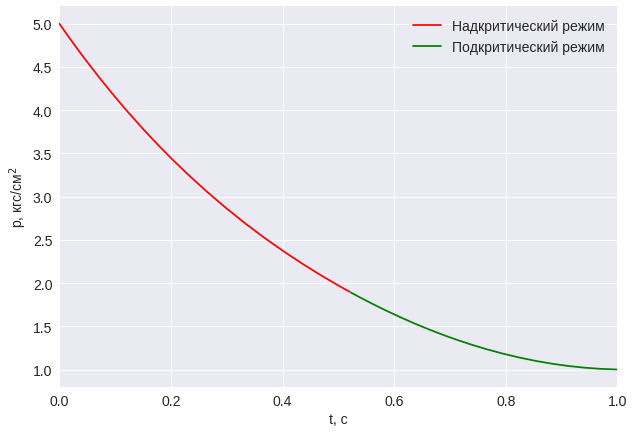

In [0]:
plt.plot(sol.t[Gt[:,0]>0],pt[Gt[:,0]>0]/1e4,'r',sol.t[Gt[:,0]<1],pt[Gt[:,0]<1]/1e4,'g');
plt.legend(['Надкритический режим','Подкритический режим'])
plt.xlim([0,1]);plt.xlabel('t, c');plt.ylabel('p, кгс/см$^2$');

График весового расхода газа

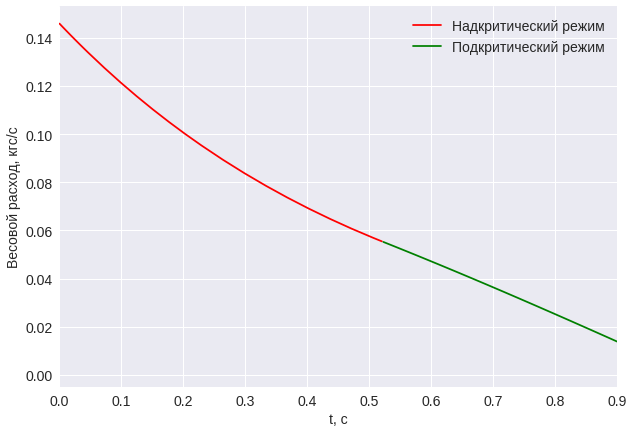

In [0]:
plt.plot(sol.t[Gt[:,0]>0],Gt[Gt[:,0]>0,1],'r',sol.t[Gt[:,0]<1],Gt[Gt[:,0]<1,1],'g');
plt.legend(['Надкритический режим','Подкритический режим'])
plt.xlim([0,0.9]);plt.xlabel('t, c');plt.ylabel('Весовой расход, кгс/c');